In [1]:
import numpy as np
import matplotlib.pyplot as plt
import transformations as tf
%matplotlib inline

In [2]:
import os

In [85]:
def dist(a, b):
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def dist_to_many(a, b_s):
    return np.sqrt((a[0] - b_s[:, 0]) ** 2 + (a[1] - b_s[:, 1]) ** 2)


def get_ate(gt_positions, slam_positions, slam_times, plot=False):
    ate = 0
    for i in range(len(slam_positions)):
        ate += dist_to_many(slam_positions[i], gt_positions).min()
    if plot:
        plt.plot(gt_positions[:, 0], gt_positions[:, 1], label='groundtruth')
        plt.plot(slam_positions[:, 0], slam_positions[:, 1], label='predicted')
        plt.legend()
        plt.show()
    return ate / len(slam_positions)

    
def get_ate_scaled(gt_positions, slam_positions, slam_times):
    min_ate = np.inf
    best_scale = None
    for scale in np.linspace(0.5, 2, 100):
        ate = get_ate(gt_positions, slam_positions * scale, slam_times)
        if ate < min_ate:
            min_ate = ate
            best_scale = scale
    plt.plot(gt_positions[:, 0], gt_positions[:, 1], label='groundtruth')
    plt.plot(slam_positions[:, 0] * best_scale, slam_positions[:, 1] * best_scale, label='predicted')
    plt.legend()
    plt.show()
    return min_ate, best_scale

across_long_corridor_fastdepth


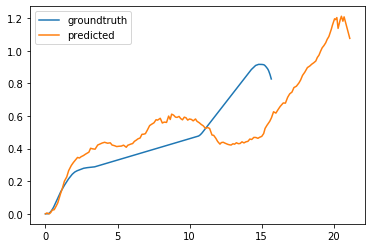

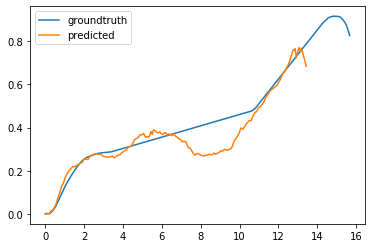

ATE is 0.8709323230785807
ATE scaled is 0.044026064145579184, with scale 0.6363636363636364

across_long_corridor_our


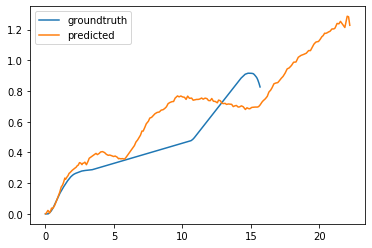

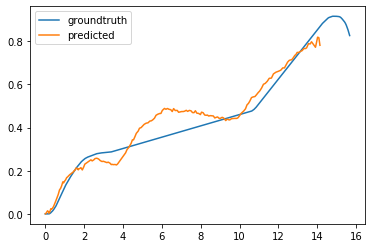

ATE is 0.9729886379924853
ATE scaled is 0.04199977836810344, with scale 0.6363636363636364

across_long_corridor_fcrn_depthwise


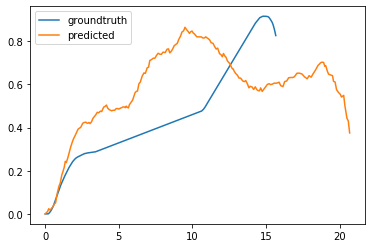

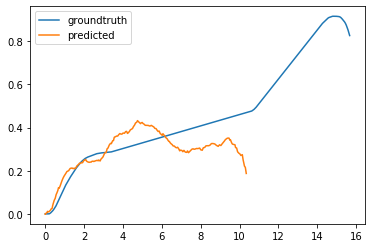

ATE is 0.6720374790298302
ATE scaled is 0.06105440157182937, with scale 0.5

corridor_to_room_fastdepth


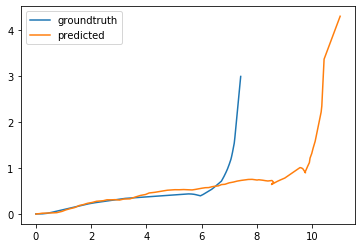

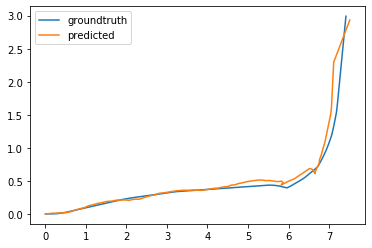

ATE is 0.8126843185635695
ATE scaled is 0.03703179342613919, with scale 0.6818181818181819

corridor_to_room_our


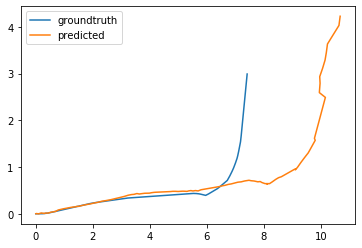

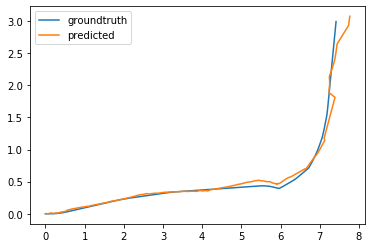

ATE is 0.7245624659548764
ATE scaled is 0.037410297575656136, with scale 0.7272727272727273

corridor_to_room_fcrn_depthwise


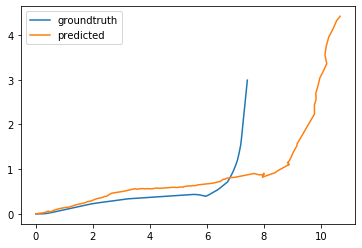

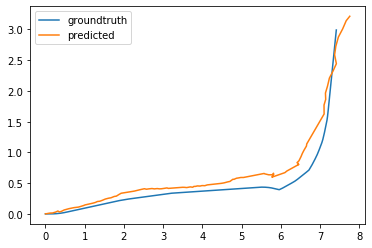

ATE is 0.7179553398158699
ATE scaled is 0.1187784673502721, with scale 0.7272727272727273



In [96]:
data_dir = '../results_trajectory/house1'
trajs = [x[:-4] for x in os.listdir('/home/kirill/FastDepth/rosbags/house1')]
trajs.sort()
slam_types = ['fastdepth', 'our', 'fcrn_depthwise']
for traj in trajs:
    for slam in slam_types:
        gt_positions = gt_positions[gt_positions[:, 2] < 0]
        gt_positions = np.loadtxt(os.path.join(data_dir, traj + '_' + slam, 'gt_positions.txt'))
        slam_positions = np.loadtxt(os.path.join(data_dir, traj + '_' + slam, 'slam_positions.txt'))
        slam_times = np.loadtxt(os.path.join(data_dir, traj + '_' + slam, 'slam_times.txt'))
        print(traj + '_' + slam)
        ate = get_ate(gt_positions, slam_positions, slam_times, plot=True)
        ate_scaled, best_scale = get_ate_scaled(gt_positions, slam_positions, slam_times)
        print('ATE is {}\nATE scaled is {}, with scale {}'.format(ate, ate_scaled, best_scale))
        print()

NameError: name 'rtabmap_kinect_poses' is not defined

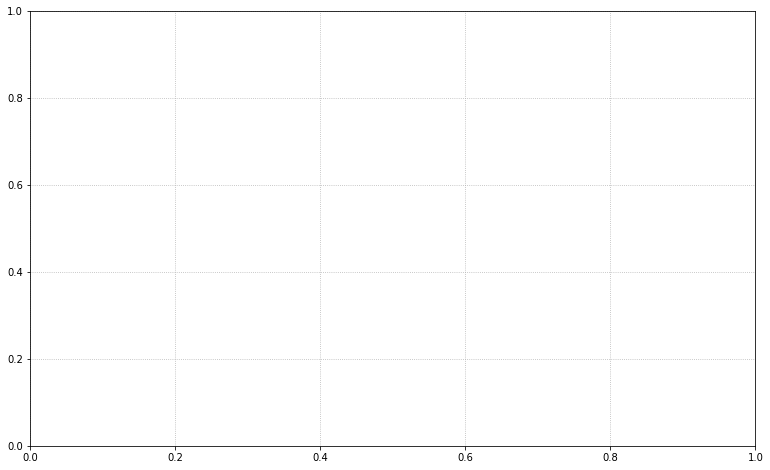

In [70]:
plt.figure(figsize=(13, 8))
plt.grid(ls=':')
plt.plot(rtabmap_kinect_poses[:, 0], rtabmap_kinect_poses[:, 1], color='r', label='Kinect trajectory')
plt.plot(rtabmap_fcnn_poses[:, 0], rtabmap_fcnn_poses[:, 1], color='y', label='FCNN trajectory')
plt.plot(gt_poses_kinect[:, 0], gt_poses_kinect[:, 1], color='g', label='Groundtruth trajectory')
plt.legend(fontsize=16)

In [11]:
def get_ate(gt_poses, slam_poses):
    gt_positions = gt_poses[:, :3]
    slam_positions = slam_poses[:, :3]
    return np.mean(np.sqrt(np.sum((slam_positions - gt_positions) ** 2, axis=1)))


def get_rel_shifts(positions, rotations):
    shifts = positions[1:] - positions[:-1]
    z_angles = rotations[:-1, 2]
    shifts_rotated = shifts.copy()
    shifts_rotated[:, 0] = shifts[:, 0] * np.cos(z_angles) + shifts[:, 1] * np.sin(z_angles)
    shifts_rotated[:, 1] = -shifts[:, 0] * np.sin(z_angles) + shifts[:, 1] * np.cos(z_angles)
    return shifts_rotated


def get_rpe(gt_poses, slam_poses):
    gt_positions = gt_poses[:, :3]
    gt_rotations = gt_poses[:, 3:]
    slam_positions = slam_poses[:, :3]
    slam_rotations = slam_poses[:, 3:]
    gt_shifts = get_rel_shifts(gt_positions, gt_rotations)
    slam_shifts = get_rel_shifts(slam_positions, slam_rotations)
    return np.mean(np.sqrt(np.sum((gt_shifts - slam_shifts) ** 2, axis=1)))

In [12]:
np.savetxt('rtabmap_kinect/slam_poses.txt', rtabmap_kinect_poses)
np.savetxt('rtabmap_fcnn/slam_poses.txt', rtabmap_fcnn_poses)

In [13]:
print('Rtabmap-kinect ATE:', get_ate(gt_poses_kinect, rtabmap_kinect_poses))
print('Rtabmap-kinect RPE:', get_rpe(gt_poses_kinect, rtabmap_kinect_poses))

Rtabmap-kinect ATE: 0.16521205343995957
Rtabmap-kinect RPE: 0.03848543603955705


In [14]:
print('Rtabmap-fcnn ATE:', get_ate(gt_poses_fcnn, rtabmap_fcnn_poses))
print('Rtabmap-fcnn RPE:', get_rpe(gt_poses_fcnn, rtabmap_fcnn_poses))

Rtabmap-fcnn ATE: 0.6671950119022353
Rtabmap-fcnn RPE: 0.06857228401268141


In [ ]:
gt_points = np.loadtxt('groundtruth/points.txt')
slam_points = np.loadtxt('rtabmap_fcnn/points.txt')

In [ ]:
import octomap
tree = octomap.OcTree(0.05)
tree.insertPointCloud(slam_points, np.array([0., 0., 0.]))

In [ ]:
def node_info(node):
    coords = [node.getX(), node.getY(), node.getZ()]
    key = node.getKey()
    size = node.getSize()
    return [coords, key, size]

occupied_nodes = [node_info(node) for node in tree.begin_tree() if node.isLeaf() and tree.isNodeOccupied(node)]

In [ ]:
sizes = np.array([x[2] for x in occupied_nodes])
print(sizes.min(), sizes.mean(), sizes.max())

In [15]:
result_filenames = []
for slam in ['kinect', 'fcnn']:
    for metric in ['abs', 'rel']:
        for choice in ['first', 'last', 'nearest', 'all']:
            result_filenames.append('rtabmap_{}_{}_{}.txt'.format(slam, metric, choice))

In [17]:
for name in result_filenames:
    point_pairs = np.loadtxt('results/' + name)
    left_points = point_pairs[:, :3]
    right_points = point_pairs[:, 3:]
    dist = np.sqrt(np.sum((left_points - right_points) ** 2, axis=1))
    mse = np.sqrt(np.mean(dist ** 2))
    mae = np.mean(dist)
    print(name[:-4])
    print('RMSE: {}; MAE: {}'.format(mse, mae))
    print()

rtabmap_kinect_abs_first
RMSE: 2.1903347463691705; MAE: 1.4505617285075678

rtabmap_kinect_abs_last
RMSE: 1.375349934540487; MAE: 0.9158043016251902

rtabmap_kinect_abs_nearest
RMSE: 0.8853423808935601; MAE: 0.6820656837167165

rtabmap_kinect_abs_all
RMSE: 0.7216750212086689; MAE: 0.4289177974670432

rtabmap_kinect_rel_first
RMSE: 1.945528849725042; MAE: 1.1862848049275527

rtabmap_kinect_rel_last
RMSE: 1.282637386558107; MAE: 0.7373987507178391

rtabmap_kinect_rel_nearest
RMSE: 0.644359984521824; MAE: 0.40191143671692325

rtabmap_kinect_rel_all
RMSE: 0.6926488291795; MAE: 0.3567039241198862

rtabmap_fcnn_abs_first
RMSE: 2.168445474753724; MAE: 1.6296444434895188

rtabmap_fcnn_abs_last
RMSE: 1.7820976565917677; MAE: 1.5655800482438313

rtabmap_fcnn_abs_nearest
RMSE: 1.63955932967564; MAE: 1.428886989663376

rtabmap_fcnn_abs_all
RMSE: 1.9359477545774457; MAE: 1.5444838577682822

rtabmap_fcnn_rel_first
RMSE: 2.153253009195173; MAE: 1.508504814403052

rtabmap_fcnn_rel_last
RMSE: 1.2876089